In [77]:
import datajoint as dj
dj.config['fetch_format'] = 'array'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from fly_session import schema, Fly, Session

Connecting root@127.0.0.1:3306


In [5]:
Fly()

fly_id Unique animal ID,dob date of birth,sex sex
0,2020-03-01,M
1,2019-11-19,M
2,2019-11-20,U
5,2019-12-25,F
10,2020-01-01,F
11,2020-01-03,F
100,2020-05-12,F


In [6]:
Session()

fly_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2020-05-15,0,gucky92,imaging_data
0,2020-05-19,0,gucky92,imaging_data
5,2020-01-05,1,jko14,imaging_data
100,2020-05-25,100,jportes,imaging_data


In [7]:
@schema
class Scan(dj.Manual):
    definition = """
    -> Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

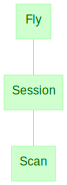

In [8]:

dj.ERD(schema)

In [13]:
Scan.insert([
    {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 1, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 
     'file_name': 'example_scan_01.tif'},
    {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 2, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 
     'file_name': 'example_scan_02.tif'},
    {'fly_id': 0, 'session_date': '2020-05-15', 'scan_idx': 3, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 
     'file_name': 'example_scan_03.tif'}
])

In [51]:
Scan()

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2020-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2020-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
0,2020-05-15,3,150.0,920.0,26.0,15.0,example_scan_03.tif


In [52]:
from skimage import io
im = io.imread('example_scan_01.tif')
print(im.shape)

(100, 128, 128)


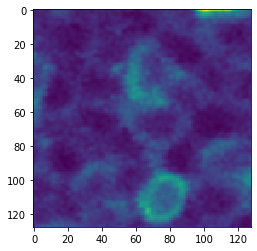

In [53]:
backgroundmean=np.mean(im,axis=(0))
plt.imshow(backgroundmean)


In [55]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """

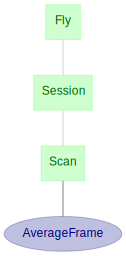

In [56]:
dj.ERD(schema)

In [78]:
AverageFrame.populate()

key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 1}
key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 2}
key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 3}


In [79]:
@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        print('key is', key)

In [80]:
AverageFrame.populate()

key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 1}
key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 2}
key is {'fly_id': 0, 'session_date': datetime.date(2020, 5, 15), 'scan_idx': 3}


In [122]:
import os
from skimage import io

@schema
class AverageFrame(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        currententry=(Scan & {'fly_id':key['fly_id'], 'session_date':key['session_date'],'scan_idx':key['scan_idx']}).fetch1()
        filename=currententry['file_name']
        im = io.imread(filename)
        key['average_frame']=np.mean(im,axis=(0))
        self.insert1(key)

In [123]:
AverageFrame.populate()

In [124]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=
0,2020-05-15,3,=BLOB=


In [125]:

AverageFrame.populate()

In [126]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=
0,2020-05-15,3,=BLOB=


In [127]:
Scan.insert1({
    'fly_id': 100,
    'session_date': '2020-05-25',
    'scan_idx': 1,
    'depth': 150,
    'wavelength': 920,
    'laser_power': 25,
    'fps': 15,
    'file_name': 'example_scan_03.tif'
})

In [128]:
Scan - AverageFrame

fly_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
100,2020-05-25,1,150.0,920.0,25.0,15.0,example_scan_03.tif


In [129]:
AverageFrame.populate()

In [130]:
AverageFrame()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=
0,2020-05-15,3,=BLOB=
100,2020-05-25,1,=BLOB=


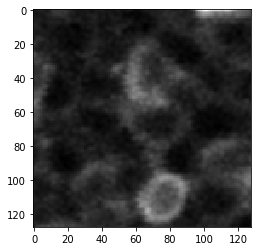

In [131]:
key = dict(fly_id=0, session_date='2020-05-15', scan_idx=1)
avg_image = (AverageFrame & key).fetch1('average_frame')
plt.imshow(avg_image, cmap=plt.cm.gray)

In [132]:
import os
from skimage import io

@schema
class Frames(dj.Imported):
    definition = """
    -> Scan
    ---
    average_frame   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        currententry=(Scan & {'fly_id':key['fly_id'], 'session_date':key['session_date'],'scan_idx':key['scan_idx']}).fetch1()
        filename=currententry['file_name']
        im = io.imread(filename)
        key['average_frame']=im
        self.insert1(key)

In [133]:
Frames.populate()

In [134]:
Frames()

fly_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2020-05-15,1,=BLOB=
0,2020-05-15,2,=BLOB=
0,2020-05-15,3,=BLOB=
100,2020-05-25,1,=BLOB=


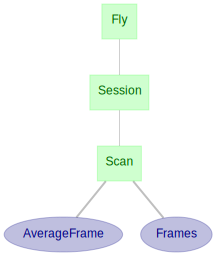

In [135]:
dj.ERD(schema)